## Setup and Configuration for Multi class Effnet

In [12]:
import os
import cv2
import json
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.models import efficientnet_b2

from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.model_selection import ParameterGrid

In [13]:
# Paths
root_path = os.path.join('..', 'dataset', 'malaria')
train_json_path = os.path.join(root_path, 'training.json')
test_json_path = os.path.join(root_path, 'test.json')
image_path = os.path.join(root_path, 'images')
models_dir = os.path.join('.', 'effnet_models')

os.makedirs(models_dir, exist_ok=True)

print("Root Path:", root_path)
print("Train JSON Path:", train_json_path)
print("Test JSON Path:", test_json_path)
print("Image Path:", image_path)

Root Path: ..\dataset\malaria
Train JSON Path: ..\dataset\malaria\training.json
Test JSON Path: ..\dataset\malaria\test.json
Image Path: ..\dataset\malaria\images


## Model and Dataset Definitions

In [14]:
class MalariaDataset(Dataset):
    """
        class for mapping images with bounding boxes
    """
    def __init__(self, json_path, image_root, transform=None, category_map=None):
        with open(json_path, 'r') as f:
            self.entries = json.load(f)
        self.image_root = image_root
        self.transform = transform

        if category_map is None:
            all_categories = set()
            for item in self.entries:
                for obj in item['objects']:
                    all_categories.add(obj['category'])
            self.category_map = {cat: idx for idx, cat in enumerate(sorted(list(all_categories)))}
        else:
            self.category_map = category_map
        
        self.labels = []
        for item in self.entries:
            if item['objects']:
                cat = item['objects'][0]['category']
                self.labels.append(self.category_map[cat])
            else:
                self.labels.append(-1)

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        entry = self.entries[idx]
        pathname_from_json = entry['image']['pathname']
        image_name = os.path.basename(pathname_from_json)
        image_full_path = os.path.join(self.image_root, image_name)

        try:
            image = Image.open(image_full_path).convert("RGB")
        except FileNotFoundError:
            print(f"Error: Image not found at {image_full_path}")
            return None # Will be filtered by collate_fn

        boxes = []
        labels = []
        for obj in entry['objects']:
            bb = obj['bounding_box']
            boxes.append([bb['minimum']['c'], bb['minimum']['r'], bb['maximum']['c'], bb['maximum']['r']])
            labels.append(self.category_map[obj['category']])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        if self.transform:
            image = self.transform(image)

        target = {'boxes': boxes, 'labels': labels}
        return image, target

### Model architecture

In [15]:
class EfficientNetDetector(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetDetector, self).__init__()
        # Loading pre-trained EfficientNet-B2 as the backbone
        self.backbone = efficientnet_b2(weights='IMAGENET1K_V1')
        
        # Replacing the final classifier with an identity layer
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()
        
        # classifier for multi-label classification
        self.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        # Pass input through the backbone
        features = self.backbone(x)
        
        # Getting class scores from the classifier
        class_scores = self.classifier(features)
        
        # return the class scores
        return class_scores

## Training and Validation Functions

In [16]:
def train_model(model, loader, optimizer, device, epoch, num_classes):
    model.train()
    running_loss, correct, total_objects = 0.0, 0, 0
    pbar = tqdm(loader, desc=f"Training Epoch {epoch}")
    
    # the loss function BCEWithLogitsLoss is ideal for multi-label tasks as it combines Sigmoid + BCE.
    # `pos_weight` forces the model to focus on rare classes by heavily penalizing mistakes on them.
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

    for images, targets_list in pbar:
        if not images.numel(): continue # Skip empty batches
        images = images.to(device)
        optimizer.zero_grad()
        
        # Getting the class scores
        class_scores = model(images)
        
        # Creating a placeholder for all target labels in the batch
        all_target_labels = torch.zeros_like(class_scores).to(device)

        # Populate the multi-hot encoded tensor
        for i, target in enumerate(targets_list):
            labels = target['labels']
            if len(labels) > 0:
                all_target_labels[i, labels] = 1.0

        # Calculate loss for the whole batch at once
        loss = criterion(class_scores, all_target_labels)

        if images.size(0) > 0:
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Apply sigmoid to get probabilities, then threshold to get predictions
        preds = torch.sigmoid(class_scores)
        preds[preds >= 0.5] = 1
        preds[preds < 0.5] = 0

        # Compare if the predicted multi-hot vector exactly matches the true one
        total_objects += images.size(0)
        correct += (preds == all_target_labels).all(dim=1).sum().item()

        pbar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_loss = running_loss / len(loader) if len(loader) > 0 else 0
    accuracy = 100 * correct / total_objects if total_objects > 0 else 0
    return epoch_loss, accuracy

def validate_model(model, loader, device, category_map, return_preds=False):
    model.eval()
    all_labels_for_report = []
    all_preds_for_report = []
    
    # Add criterion to calculate loss
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
    running_loss = 0.0
    
    pbar = tqdm(loader, desc="Validating")

    with torch.no_grad():
        for images, targets_list in pbar:
            if not images.numel(): continue
            images = images.to(device)
            
            class_scores = model(images)
            
            # Create the true multi-hot labels for the batch
            true_labels = torch.zeros_like(class_scores)
            for i, target in enumerate(targets_list):
                labels = target['labels']
                if len(labels) > 0:
                    true_labels[i, labels] = 1.0
            
            # --- NEW: Calculate and accumulate loss ---
            loss = criterion(class_scores, true_labels)
            running_loss += loss.item()

            # Get predictions
            preds = torch.sigmoid(class_scores)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            all_preds_for_report.extend(preds.cpu().numpy())
            all_labels_for_report.extend(true_labels.cpu().numpy())

    if return_preds:
        return all_labels_for_report, all_preds_for_report
    else:
        # --- MODIFIED: Return loss and accuracy ---
        epoch_loss = running_loss / len(loader) if len(loader) > 0 else 0
        accuracy = 100 * np.mean(np.array(all_labels_for_report) == np.array(all_preds_for_report))
        return epoch_loss, accuracy

## Main Training Pipeline

In [17]:
# Custom collate_fn to filter out None values from the batch
def custom_collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    if not batch:
        return torch.tensor([]), []
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    images = torch.stack(images, dim=0)
    return images, targets

In [18]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- Pre-calculation of Class Weights ---
# This is efficient because it doesn't change between runs.
with open(train_json_path, 'r') as f:
    train_entries = json.load(f)
temp_ds = MalariaDataset(train_json_path, image_path) # Temp dataset to get map
category_map = temp_ds.category_map
num_classes = len(category_map)
print(f"Found {num_classes} classes: {category_map}")

print("Calculating class weights for the loss function...")
multi_hot_labels = np.zeros((len(train_entries), num_classes), dtype=float)
for i, entry in enumerate(train_entries):
    for obj in entry['objects']:
        cat_idx = category_map.get(obj['category'])
        if cat_idx is not None:
            multi_hot_labels[i, cat_idx] = 1.0
positive_counts = multi_hot_labels.sum(axis=0)
total_samples = len(train_entries)
pos_weight = (total_samples - positive_counts) / (positive_counts + 1e-6)
pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float).to(DEVICE)
print(f"Calculated pos_weight: {pos_weight_tensor.cpu().numpy()}")


# --- Define Hyperparameter Grid for the Search ---
param_grid = {
    'lr': [0.001, 0.0005],
    'optimizer': ['Adam', 'SGD'],
    'batch_size': [16, 32],
    'image_size': [224],
    'sampling': ['oversample', None]
}

# --- Setup for tracking results ---
results = []
grid = list(ParameterGrid(param_grid))

Using device: cpu
Found 7 classes: {'difficult': 0, 'gametocyte': 1, 'leukocyte': 2, 'red blood cell': 3, 'ring': 4, 'schizont': 5, 'trophozoite': 6}
Calculating class weights for the loss function...
Calculated pos_weight: [ 2.5321636  7.882353  11.851064   0.         3.9508197  6.6942673
  1.0268457]


In [19]:
# Helper function for the sampler
def create_sampler(train_ds):
    class_counts = np.bincount([label for label in train_ds.labels if label != -1], minlength=num_classes)
    class_weights = 1. / (class_counts + 1e-6)
    sample_weights = np.array([class_weights[t] if t != -1 else 0 for t in train_ds.labels])
    return WeightedRandomSampler(torch.from_numpy(sample_weights).double(), len(sample_weights))

def run_experiment(params):
    """
    Runs a full training and validation experiment for a given set of hyperparameters.
    """
    print("\n" + "="*50)
    print(f"Params: {params}")
    print("="*50)

    start_time = time.time()

    # --- 1. Setup Transforms, Datasets, and DataLoaders ---
    transform = transforms.Compose([
        transforms.Resize((params['image_size'], params['image_size'])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_ds = MalariaDataset(train_json_path, image_path, transform=transform, category_map=category_map)
    test_ds = MalariaDataset(test_json_path, image_path, transform=transform, category_map=category_map)

    sampler = None
    shuffle = True
    if params['sampling'] == 'oversample':
        print("Applying weighted oversampling...")
        sampler = create_sampler(train_ds)
        shuffle = False

    train_loader = DataLoader(train_ds, batch_size=params['batch_size'], shuffle=shuffle, sampler=sampler, collate_fn=custom_collate_fn)
    val_loader = DataLoader(test_ds, batch_size=params['batch_size'], shuffle=False, collate_fn=custom_collate_fn)

    # --- 2. Initialize Model and Optimizer ---
    model = EfficientNetDetector(num_classes=num_classes).to(DEVICE)
    if params['optimizer'] == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    elif params['optimizer'] == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=params['lr'], momentum=0.9)

    # --- 3. Training Loop ---
    history = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}
    best_val_accuracy = 0.0
    NUM_EPOCHS = 10

    for epoch in range(1, NUM_EPOCHS + 1):
        train_loss, train_acc = train_model(model, train_loader, optimizer, DEVICE, epoch, num_classes)
        val_loss, val_acc = validate_model(model, val_loader, DEVICE, category_map)
        
        print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            print(f"New best model! Val Accuracy: {best_val_accuracy:.2f}%")
            
            sampling_str = params['sampling'] if params['sampling'] is not None else 'none'
            model_filename = (f"model_lr-{params['lr']}_optim-{params['optimizer']}_bs-{params['batch_size']}_sampling-{sampling_str}.pth")
            save_path = os.path.join(models_dir, model_filename)

            torch.save({'model_state_dict': model.state_dict(), 'params': params}, save_path)
            print(f"Model saved to {save_path}")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Finished experiment. Best validation accuracy: {best_val_accuracy:.2f}%")
    print(f"Total time: {elapsed_time / 60:.2f} minutes")

    return {
        'params': params,
        'best_accuracy': best_val_accuracy,
        'training_time_minutes': elapsed_time / 60,
        'history': history 
    }

In [20]:
import re
import os
import json
import pandas as pd
from tqdm import tqdm

# --- 1. Define the path for the final JSON file ---
results_filepath = os.path.join(models_dir, 'grid_search_results.json')
recovered_results = []
print(f"Scanning for models in: {models_dir}")

# Get a list of all saved model files
model_files = [f for f in os.listdir(models_dir) if f.endswith('.pth')]
print(f"Found {len(model_files)} saved models to process.")

# --- 2. Loop through each model file to recover its data ---
for model_filename in tqdm(model_files, desc="Recovering model results"):
    model_path = os.path.join(models_dir, model_filename)

    # --- 3. Parse the filename to reconstruct the parameters ---
    # This pattern extracts the values based on the filename structure
    pattern = r"model_lr-(.*)_optim-(.*)_bs-(.*)_sampling-(.*)\.pth"
    match = re.match(pattern, model_filename)
    
    if not match:
        print(f"Skipping file with unrecognized name format: {model_filename}")
        continue
        
    lr, optimizer, batch_size, sampling = match.groups()
    
    # Reconstruct the params dictionary, converting types as needed
    params = {
        'lr': float(lr),
        'optimizer': optimizer,
        'batch_size': int(batch_size),
        'sampling': sampling if sampling != 'none' else None,
        'image_size': 224 # Assuming this was constant
    }

    # --- 4. Load the model and re-run validation to get its accuracy ---
    checkpoint = torch.load(model_path, map_location=DEVICE)
    
    model = EfficientNetDetector(num_classes=num_classes).to(DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Create a temporary dataloader for validation
    temp_test_loader = DataLoader(
        test_ds, 
        batch_size=int(batch_size), 
        shuffle=False, 
        collate_fn=custom_collate_fn
    )
    
    # Re-calculate the validation accuracy and loss
    val_loss, val_accuracy = validate_model(model, temp_test_loader, DEVICE, category_map)
    
    # --- 5. Build the result dictionary ---
    # Note: We cannot recover the epoch-by-epoch history or exact training time.
    recovered_results.append({
        'params': params,
        'best_accuracy': val_accuracy,
        'model_path': model_path,
        'training_time_minutes': None, # This data is lost
        'history': None # This data is lost
    })

# --- 6. Save the recovered results to the JSON file ---
with open(results_filepath, 'w') as f:
    json.dump(recovered_results, f, indent=4)

print(f"\n--- Recovery Complete! ---")
print(f"Successfully processed {len(recovered_results)} models.")
print(f"Results have been saved to: {results_filepath}")

Scanning for models in: .\effnet_models
Found 15 saved models to process.


Recovering model results:   0%|          | 0/15 [00:00<?, ?it/s]C:\Users\shera\AppData\Local\Temp\ipykernel_9312\1774310763.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature

NameError: name 'test_ds' is not defined

##  Final Validation

In [ ]:
# --- 1. Identify and Load the Best Model from the Grid Search ---
print("--- Starting Final Evaluation on the Best Model ---")

# Get the details of the best run from our results DataFrame
best_run = results_df_sorted.iloc[0]
best_model_path = best_run['model_path']
best_params = best_run.to_dict()

print(f"Loading best model from: {best_model_path}")
print(f"Best model parameters found: {best_params}")

# Load the checkpoint dictionary from the saved file
checkpoint = torch.load(best_model_path, map_location=DEVICE)

# Initialize a new model instance and load the state_dict from the checkpoint
eval_model = EfficientNetDetector(num_classes=num_classes).to(DEVICE)
eval_model.load_state_dict(checkpoint['model_state_dict'])


# --- 2. Create a Test DataLoader with the Best Batch Size ---
final_test_loader = DataLoader(
    test_ds, 
    batch_size=best_params['batch_size'], 
    shuffle=False, 
    collate_fn=custom_collate_fn
)


# --- 3. Get Final Predictions on the Test Set ---
# Pass the correct test loader to the validation function
y_true, y_pred = validate_model(eval_model, final_test_loader, DEVICE, num_classes, category_map, return_preds=True)


# --- 4. Save Prediction Results and Generate Reports ---
# This part is the same as your original code
results_filepath = os.path.join(models_dir, 'best_model_validation_results.npz')
np.savez_compressed(
    results_filepath,
    true_labels=y_true,
    pred_labels=y_pred,
    class_names=class_names
)
print(f"\nValidation results saved to: {results_filepath}")

class_names = [name for name, index in sorted(category_map.items(), key=lambda item: item[1])]
labels_for_report = list(range(len(class_names)))

# Classification Report
print("\n--- Classification Report ---")
report = classification_report(
    y_true, 
    y_pred, 
    target_names=class_names,
    labels=labels_for_report,
    zero_division=0
)
print(report)

--- Starting Final Evaluation on Test Set ---
Loaded best model from .\efficientnet_models\best_model.pth


Validating: 100%|██████████| 4/4 [00:14<00:00,  3.64s/it]


--- Classification Report ---
                precision    recall  f1-score   support

     difficult       0.00      0.00      0.00         5
    gametocyte       0.00      0.00      0.00        11
     leukocyte       0.00      0.00      0.00         0
red blood cell       1.00      0.62      0.77       120
          ring       0.43      0.61      0.50        57
      schizont       0.00      0.00      0.00         9
   trophozoite       1.00      0.03      0.07        59

     micro avg       0.66      0.43      0.52       261
     macro avg       0.35      0.18      0.19       261
  weighted avg       0.78      0.43      0.48       261
   samples avg       0.53      0.43      0.46       261




--- Per-Class Confusion Matrices ---


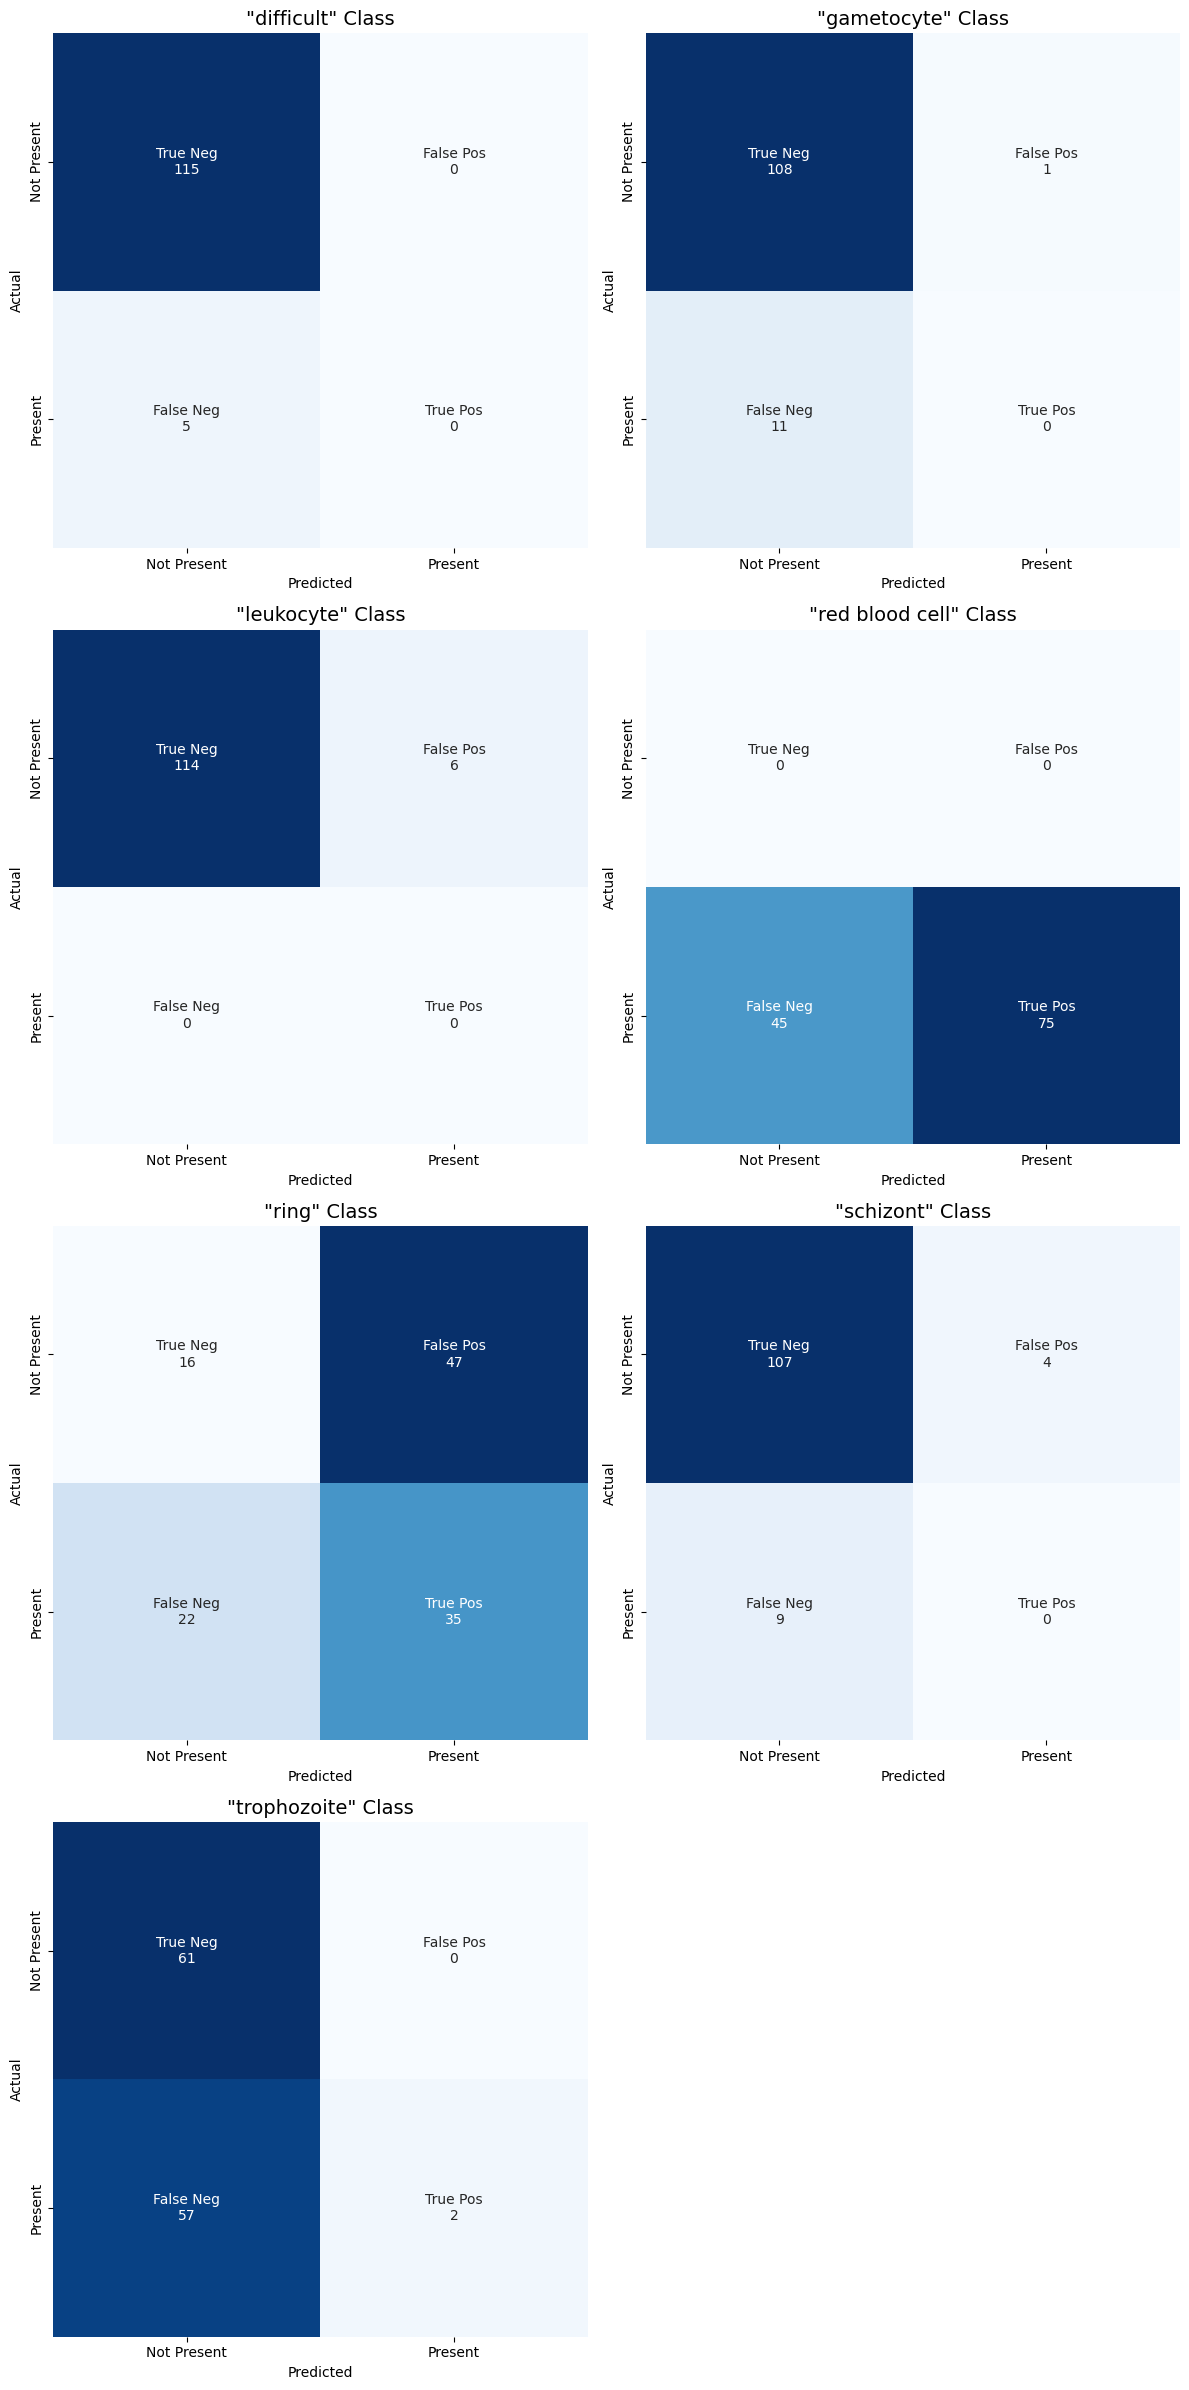

In [ ]:
# --- 1. Generate the multi-label confusion matrices ---
mcm = multilabel_confusion_matrix(y_true, y_pred, labels=labels_for_report)

# --- 2. Plot a confusion matrix for each class ---
print("\n--- Per-Class Confusion Matrices ---")
# Create a subplot for each class
# Adjust nrows and ncols based on how many classes you have
nrows = (len(class_names) + 1) // 2
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(12, nrows * 6))
axes = axes.flatten() # Flatten the axes array for easy iteration

for i, class_name in enumerate(class_names):
    ax = axes[i]
    # Get the 2x2 matrix for the current class
    matrix = mcm[i]
    
    # Format the labels for the heatmap
    group_counts = [f"{value}" for value in matrix.flatten()]
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'"{class_name}" Class', fontsize=14)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_xticklabels(['Not Present', 'Present'])
    ax.set_yticklabels(['Not Present', 'Present'])

# Hide any unused subplots
for i in range(len(class_names), len(axes)):
    fig.delaxes(axes[i])
    
plt.tight_layout()
plt.show()